In [ ]:
!pip install contractions
!pip install autocorrect
!pip install unidecode
!pip install num2words


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 6.9 MB/s 
     |████████████████████████████████| 287 kB 52.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 622 kB 8.4 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=8aa8b6f2aabb472b41bdc56e016d5c94f453ea457902cbabd58c2c43ae348e2a
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.7 MB/s 
  Created wheel for

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import unidecode
import nltk
nltk.download('punkt')

import num2words

from autocorrect import Speller
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Exploration du jeu de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_FILE = "/content/drive/MyDrive/TP_NLP/Dataset/avisClients.csv"

In [ ]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


In [ ]:
dataset_df.columns

Index(['text', 'stars'], dtype='object')

## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [ ]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [ ]:
stars_columns.value_counts()

1    5000
2    5000
3    5000
4    5000
5    5000
Name: stars, dtype: int64

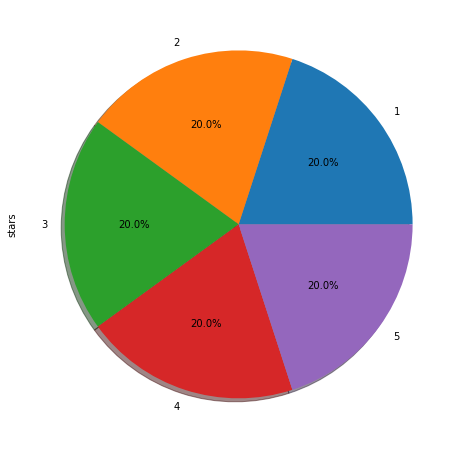

In [ ]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [ ]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df["text"][150]

'We had heard wonderful things about Coquine, so were really looking forward to lunch there.  Initially we were very surprised at the extremely small portions.  I prefer small portions and usually order appetizer or small plates for a main dish.  The orrcichiette  pasta was no more than a half a cup serving, ridiculously small.  The porchetta sandwich looked more reasonable, but there was one layer of very thin meat and a bunch of cabbage.  I shared it with my friend because of the tiny size of her pasta dish.  I ordered the creme fraiche ice cream and was shocked at the single melon ball size scoop.  At that point I felt insulted to be charged $4 for a couple of tablespoons of ice cream no matter how good it was.  \n\nBefore writing I checked other reviews to see if anyone had the same experience and found many similar reviews.  Obviously, the owners of Coquine do not care.  It is an insult to customers to charge fairly high prices for such unreasonably small portions.  The food is ge

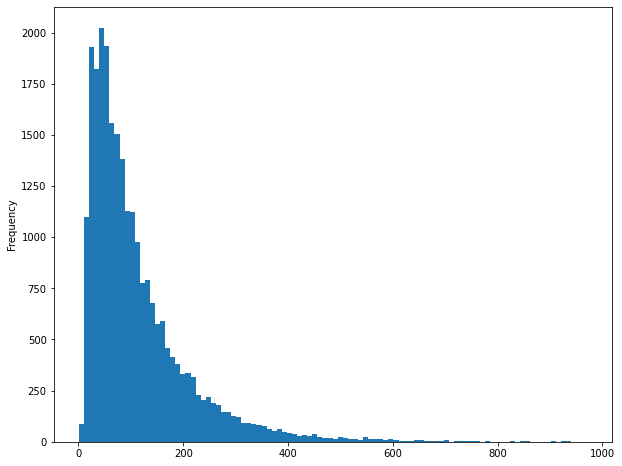

In [ ]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

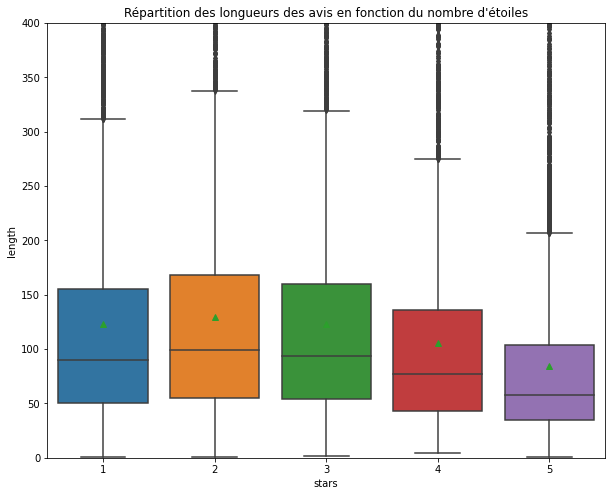

In [ ]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [265]:
### Texte en minuscule
def lower_case_convertion(text):
	lower_text = text.lower()
	return lower_text

### Suppression des tags HTML
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

# Suppression des URLS
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+'
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

### Conversion des mots en nombre
def num_to_words(text):
	# splitting text into words with space
	after_spliting = text.split()

	for index in range(len(after_spliting)):
		if after_spliting[index].isdigit():
			after_spliting[index] = num2words(after_spliting[index])

    # joining list into string with space
	numbers_to_words = ' '.join(after_spliting)
	return numbers_to_words

def num_to_words2(text):
  for index in range(len(text)):
     if text[index].isdigit() :
        text[index] = num2words(text[index])
  return text

# Correction orthographe
#### Très long
def spell_autocorrect(text):

	correct_spell_words = []

	# initialize Speller object for english language with 'en'
	spell_corrector = Speller(lang='en')
	for word in word_tokenize(text):
		# correct spell word
		correct_word = spell_corrector(word)
		correct_spell_words.append(correct_word)

	correct_spelling = ' '.join(correct_spell_words)
	return correct_spelling

#ASCII
def accented_to_ascii(text):

	# apply unidecode function on text to convert
	# accented characters to ASCII values
	text = unidecode.unidecode(text)
	return text

### Contraction
def expand_contractions(text):
  ### We can use the dict : https://stackoverflow.com/questions/60901735/importerror-cannot-import-name-contraction-map-from-contractions
	return contractions.fix(text)


#######################################################################################################################################

### Suppresion de la ponctuation 
import string

def remove_punctuation(text) :
  return text.translate(str.maketrans('', '', string.punctuation))


In [266]:
def preprocessing(text) :
  text = lower_case_convertion(text)
  text = remove_html_tags(text)
  text = remove_urls(text)
  #text = num_to_words(text)
  #text = spell_autocorrect(text)
  text = accented_to_ascii(text)
  text =  expand_contractions(text)
  text = remove_punctuation(text)
  return text 



In [267]:
dataset_df_preprocess = dataset_df.copy()
for i,text in enumerate(dataset_df['text']) :
  dataset_df_preprocess['text'][i] = preprocessing(text)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [268]:
#### Création des tokens négatifs

def tag_words(sentence_tokenized):

    keywordSet = {"never", "nothing", "nowhere", "none", "not"}

    for word in sentence_tokenized:
      if (word in keywordSet) and (sentence_tokenized.index(word) < len(sentence_tokenized)-1):
        sentence_tokenized[sentence_tokenized.index(word)+1]=sentence_tokenized[sentence_tokenized.index(word)+1] + '_NEG'
        sentence_tokenized.pop(sentence_tokenized.index(word))
    return sentence_tokenized



In [269]:
#### Ajout des tokens négatifs et retrait des keywordsSet du dataset 
for i,text in enumerate(dataset_df_preprocess['text']) :
  tokens = word_tokenize(text)
  tokens = tag_words(tokens)
  dataset_df_preprocess['text'][i] = ' '.join(tokens)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [270]:
dataset_df_preprocess['text']

0        i have only had food from here once and it was...
1        i will return_NEG here again ever i was sittin...
2        i wish my experience was great as others i din...
3        are the rosemary grapefruit scones supposed to...
4        our takeout order was half wrong food was miss...
                               ...                        
24995    i was a loyal fan of aroy before the ownership...
24996    stopped here for a bite while wandering around...
24997    a quiet place with excellent food great music ...
24998    super delicious food awesome vibe i suffered t...
24999    i have a lot of dietary restrictions and this ...
Name: text, Length: 25000, dtype: object

In [271]:
#### Trouvons les mots les plus fréquents

def countWords(dataset):
  from collections import Counter
  split_it = dataset.split()
  # Pass the split_it list to instance of Counter class.
  Counter = Counter(split_it)
  most_occur = Counter.most_common() 
  return most_occur

In [272]:
all_texts_dataset = ""
for text in dataset_df_preprocess['text'] :
  all_texts_dataset += text

In [274]:
most_occur_dict = dict(countWords(all_texts_dataset))

In [273]:
print(countWords(all_texts_dataset))

[('the', 146618), ('and', 93688), ('i', 77831), ('a', 69982), ('to', 63952), ('was', 58421), ('it', 45049), ('is', 44360), ('of', 41620), ('for', 33365), ('in', 28999), ('we', 26460), ('but', 25595), ('that', 25317), ('with', 22723), ('my', 22058), ('they', 20374), ('this', 20163), ('have', 19807), ('you', 19628), ('on', 19583), ('food', 19150), ('were', 18249), ('had', 17403), ('are', 15539), ('at', 14541), ('good', 14383), ('so', 13941), ('place', 13405), ('there', 11595), ('as', 11002), ('be', 10963), ('our', 10691), ('would', 10670), ('just', 9571), ('if', 9569), ('out', 9428), ('like', 9381), ('service', 9249), ('very', 9165), ('all', 9014), ('will', 8912), ('here', 8835), ('do', 8733), ('me', 8707), ('great', 8077), ('one', 8052), ('did', 7980), ('when', 7864), ('time', 7694), ('or', 7689), ('their', 7621), ('from', 7248), ('get', 7185), ('up', 7078), ('can', 6877), ('which', 6836), ('am', 6781), ('no', 6627), ('about', 6626), ('back', 6613), ('an', 6501), ('us', 6341), ('really'

In [275]:
### Nous considérons que les mots les plus fréquents sont ceux qui apparaissent plus de 10 000 fois dans le dataset 
new_stop_words = [word for word in most_occur_dict.keys() if most_occur_dict.get(word) > 10000 ]
print(len(new_stop_words))

34


In [276]:
### Stop words 
nltk.download('stopwords')

###Ajout des mots les plus fréquents au stop-words
stop_words = stopwords.words('english') + new_stop_words

for i,text in enumerate(dataset_df_preprocess['text']) :

  tokens = word_tokenize(text)
  tokens_without_sw = [word for word in tokens if not word in stop_words]
  dataset_df_preprocess['text'][i] = ' '.join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [277]:
# Fonction pour additionner deux dictionnaires
def merge(dict1, dict2):
    for i in dict2.keys():
        dict1[i]=dict2[i]
    return dict1

In [278]:
### POS_TAGGING

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
lmtzr = WordNetLemmatizer()
all_tag_words = {}
for text in dataset_df_preprocess['text'] :
  tokens = word_tokenize(text)
  
  tagged = dict(nltk.pos_tag(tokens))
  all_tag_words = merge(tagged, all_tag_words)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [279]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# initialize lemmatizer object
lemma = WordNetLemmatizer()    

  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [280]:
### Lemmatize with POS tagging 
for i,text in enumerate(dataset_df_preprocess['text']) :
	tokens = ''.join(dataset_df_preprocess['text'][i]).split()
	for i,token in enumerate(tokens) :
		try :
			tokens[i] = lemma.lemmatize(token,get_wordnet_pos(all_tag_words[token]))
		except : 
			pass
	dataset_df_preprocess['text'][i] = ' '.join(tokens)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [281]:
####Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset_df_preprocess['text'], dataset_df_preprocess['stars'], test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


clf = LogisticRegression()
clf.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [282]:
important_tokens_1 = pd.DataFrame(
    data=clf.coef_[0],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

important_tokens_2 = pd.DataFrame(
    data=clf.coef_[1],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

important_tokens_3 = pd.DataFrame(
    data=clf.coef_[2],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

important_tokens_4 = pd.DataFrame(
    data=clf.coef_[3],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

important_tokens_5 = pd.DataFrame(
    data=clf.coef_[4],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [283]:
motsPositifs = []
important_tokens_4_first_positifs = important_tokens_4.tail(15)
important_tokens_5_first_positifs = important_tokens_5.tail(15)
motsPositifs = list(important_tokens_4_first_positifs.index) + list(important_tokens_5_first_positifs.index)

In [284]:
### Supprimons les mots connotés positivement dans les avis avec 1 ou 2 *

def suppressionsMotsPositifs(motsPositifs, df_dataset_preprocess ) :
  df = df_dataset_preprocess[df_dataset_preprocess['stars'].isin([1, 2])]
  for i,text in enumerate(df['text']) :
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if not word in motsPositifs ]
    df['text'][i] = ' '.join(tokens)
  return df


In [285]:
df = suppressionsMotsPositifs(motsPositifs, dataset_df_preprocess )
dataset_df_preprocess[dataset_df_preprocess['stars'].isin([1])] = df[df['stars'].isin([1])]
dataset_df_preprocess[dataset_df_preprocess['stars'].isin([2])] = df[df['stars'].isin([2])]
                                                                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [286]:
dataset_df_preprocess.to_csv("dataset_preprocessed_InesARIF.csv",index=False)